I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [255]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [256]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

In [257]:
import numpy as np
from glob import glob
from os import path
from copy import deepcopy

In [258]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [259]:
print np.sqrt(np.diag(shape_noise_covmat))

[ 1.0263207   0.98494148  0.90722623  0.69274081  0.57677226  0.45103709
  0.32990732  0.23736836  0.17742547  0.13398334  0.10010477  0.07595037
  0.05802125  0.04515957  0.03575584  0.02910926  0.02429026  0.02063339]


In [260]:
darksky_h = 0.7036893781978598

In [261]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v3/'

In [262]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???.npy')))
print len(outputs)

70


In [263]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [264]:
2*18+14

50

In [265]:
for i,output_file in enumerate(outputs):
    if i == 0:
        continue
    output = np.load(output_file)
    all_outputs[i] = output#.mean(axis = 0)


In [266]:
all_outputs[0] = all_outputs[1:].mean(axis = 0)

In [267]:
all_outputs.shape

(70, 5, 50)

In [268]:
# undo a little h error of mine. 
# WARNING i've since corrected this so it will no longer be necessary with new computations
#all_outputs[:, :, 18:36]*=darksky_h**2

In [269]:
# I'm waiting for my v3 calculation to finish. In the interim i will just divide out the h scaling of wp (ds is already corrected)
all_outputs[:, :, :18]*=darksky_h**2

In [270]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [271]:
cic_bins

array([   1.,    2.,    3.,    4.,    6.,    7.,    8.,    9.,   10.,
         15.,   22.,   32.,   46.,   68.,  100.])

In [272]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

In [273]:
all_outputs[:,4,:18]

array([[ 1326.15354585,  1068.91469872,   854.20939638, ...,
            7.20321476,     4.19690649,     2.11042983],
       [ 1283.18945358,  1056.72185793,   841.25873962, ...,
            7.22113922,     4.16319629,     2.09697773],
       [ 1321.69201659,  1047.85806455,   828.6433671 , ...,
            6.94020884,     3.970405  ,     1.88665573],
       ..., 
       [ 1410.60914245,  1113.45114756,   906.14433335, ...,
            7.33838853,     4.34294495,     2.22218743],
       [ 1320.58066943,  1062.47264942,   849.6847211 , ...,
            7.38751466,     4.43512284,     2.34536154],
       [ 1269.49472333,  1028.61971365,   821.12368198, ...,
            6.80823915,     4.00431428,     1.96433014]])

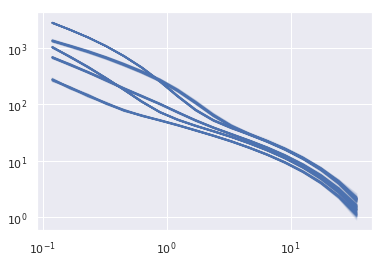

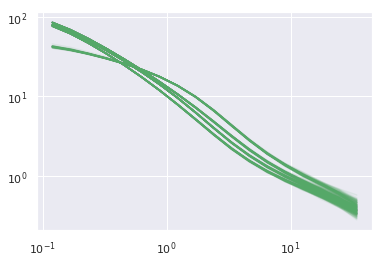

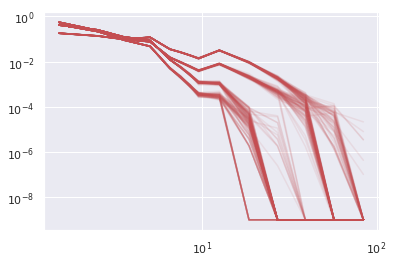

In [274]:
for hod_idx in xrange(5):
    color = 'b' 
    plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.1, color = color)
    plt.loglog();
plt.show();
for hod_idx in xrange(4):
    plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.1, color = 'g')
    plt.loglog();
plt.show();

for hod_idx in xrange(4):
    plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.1, color = 'r')
    plt.loglog();
plt.show();

In [275]:
mean = all_outputs.mean(axis = 0)

In [276]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

In [277]:
np.zeros(len(cic_bins)-1)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [278]:
# from my HOD mock on planck
#planck_y = np.array([3.67046115e+03, 2.68587097e+03, 1.86704547e+03, 1.33957041e+03,
#       9.30848932e+02, 6.45761466e+02, 4.44257796e+02, 3.02746585e+02,
#       2.09074584e+02, 1.52330606e+02, 1.14548962e+02, 8.90682088e+01,
#       6.94674502e+01, 5.30164183e+01, 3.92803031e+01, 2.74329581e+01,
#       1.77901804e+01, 1.03439673e+01, 8.12760963e+01, 6.53112366e+01,
#       5.11718897e+01, 3.92571969e+01, 2.95591990e+01, 2.18952850e+01,
#       1.59647482e+01, 1.14391216e+01, 7.99808271e+00, 5.44370980e+00,
#       3.61379155e+00, 2.33425032e+00, 1.55491234e+00, 1.10505031e+00,
#       8.02946770e-01, 6.28019530e-01, 5.08370232e-01, 4.01059480e-01,
#      0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.              ])

In [279]:
# from my HOD mock on Box 1 
# for the time being, a place holder with the right h scaling 
import numpy as np
wp_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_wp.npy')
ds_hod = np.load('/home/users/swmclau2/Git/pearce/bin/mock_measurements/HOD4mock_ds.npy')

planck_y = np.r_[wp_hod, ds_hod, np.zeros(len(cic_bins)-1)]

In [280]:
planck_y.shape

(50,)

In [281]:
mean = all_outputs.mean(axis = 0)
R =(all_outputs - mean)

corr = np.zeros((R.shape[2], R.shape[2]))
yerr_ratio = np.zeros((R.shape[2]))
for i in xrange(R.shape[1]):
    c= R[:,i].T.dot(R[:,i])/(N-1)
    corr += cov_to_corr(c)
    yerr_ratio += np.sqrt(np.diag(c))/mean[i]
    
    
corr/= (mean.shape[0])#*(N-1)
yerr_ratio/=(mean.shape[0])

In [282]:
print yerr_ratio

[ 0.01772151  0.0165684   0.01699054  0.01621152  0.01621031  0.01597432
  0.01563625  0.01625811  0.01665975  0.01537595  0.01472091  0.01403948
  0.01488573  0.01730812  0.02076087  0.02790995  0.03943242  0.07434265
  0.00912407  0.00683452  0.0052626   0.00480401  0.00405593  0.00411001
  0.00464026  0.00590287  0.00803387  0.0101094   0.01281873  0.01420545
  0.01649232  0.02011269  0.02937943  0.03907351  0.04986536  0.07350543
  0.00786414  0.00801934  0.00975554  0.01099506  0.02232893  0.03451945
  0.04316474  0.06229327  0.07559173  0.36379301  2.03607616  0.23239336
  0.91437838  2.49232334]


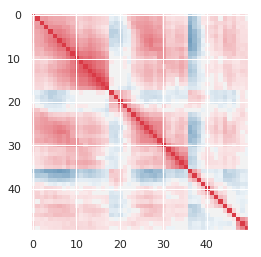

In [283]:
plt.imshow(corr, cmap = cmap, vmin=-1)

In [284]:
yerr = yerr_ratio*planck_y
cov = corr*np.outer(yerr, yerr)

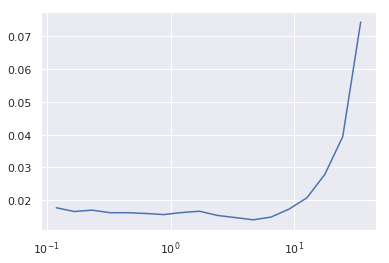

In [285]:
plt.plot(rp_points, np.sqrt(np.diag(cov))[:18]/wp_hod)
plt.xscale('log')

In [286]:
cov.shape

(50, 50)

In [287]:
np.min(cov)

-1.5634034533750112

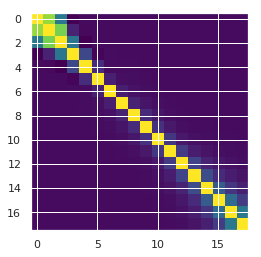

In [288]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [289]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[  1.00000000e+00   8.42406214e-01   3.86208997e-01  -2.93016279e-02
   -1.97547565e-04]
 [  8.42406214e-01   1.00000000e+00   7.88979947e-01   7.39946700e-02
   -3.67370677e-03]
 [  3.86208997e-01   7.88979947e-01   1.00000000e+00   3.73641155e-01
   -2.94861577e-02]
 [ -2.93016279e-02   7.39946700e-02   3.73641155e-01   1.00000000e+00
    1.92649413e-01]
 [ -1.97547565e-04  -3.67370677e-03  -2.94861577e-02   1.92649413e-01
    1.00000000e+00]]


In [290]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [291]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


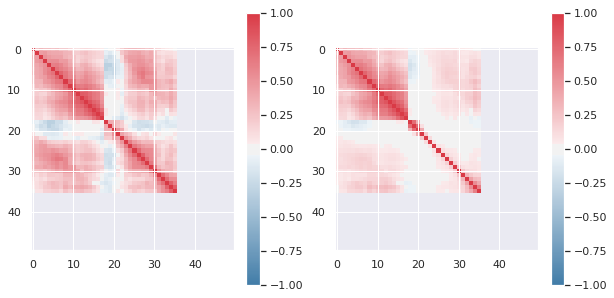

In [292]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

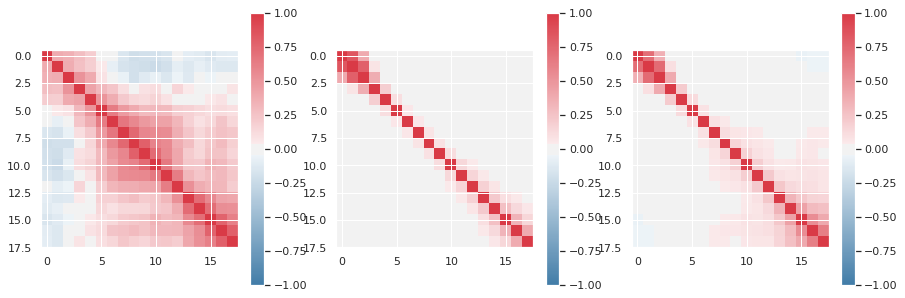

In [293]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [294]:
np.sqrt(np.diag(full_corr)[18:36])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.])

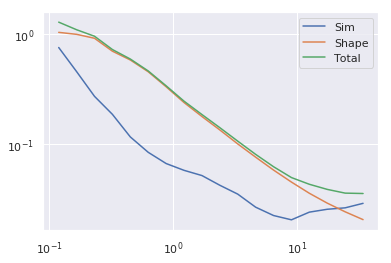

In [295]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [296]:
print full_corr[30:30+5][:, 30:30+5]

[[ 1.          0.2296839   0.12820725  0.10410437  0.09609146]
 [ 0.2296839   1.          0.32892499  0.21959598  0.15994938]
 [ 0.12820725  0.32892499  1.          0.43153485  0.29062348]
 [ 0.10410437  0.21959598  0.43153485  1.          0.54101359]
 [ 0.09609146  0.15994938  0.29062348  0.54101359  1.        ]]


In [297]:
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_full_covmat_h.npy', full_cov[:36][:, :36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_full_covmat_h.npy', full_cov[:18][:, :18])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/ds_full_covmat_h.npy', full_cov[18:36][:, 18:36])
np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_ds_sim_covmat_h.npy', cov[:36][:, :36])

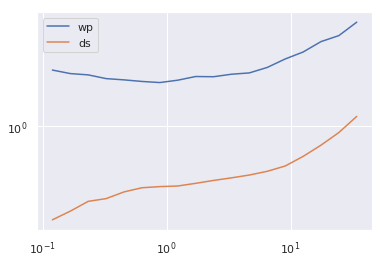

In [298]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [299]:
print np.sqrt(np.diag(full_cov[:36][:,:36]))

[ 25.7741208   17.22257381  12.02962924   8.00308653   5.59468896
   3.88693274   2.72559595   2.0493232    1.58229138   1.12971087
   0.85193352   0.62722262   0.50205644   0.42668726   0.35176942
   0.31103985   0.25167952   0.23657401   1.27010529   1.083857
   0.94657986   0.71715728   0.58828802   0.45879731   0.33654353
   0.24428288   0.1848208    0.14049072   0.10609099   0.0805237
   0.06222359   0.049617     0.04313444   0.03877514   0.03586862
   0.03558156]


In [300]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[ 1.27010529  1.083857    0.94657986  0.71715728  0.58828802  0.45879731
  0.33654353  0.24428288  0.1848208   0.14049072  0.10609099  0.0805237
  0.06222359  0.049617    0.04313444  0.03877514  0.03586862  0.03558156]


In [301]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [302]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [303]:
emu_corr = cov_to_corr(emu_cov)

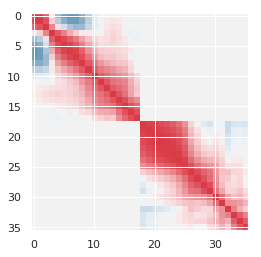

In [304]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [305]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [306]:
print np.sqrt(np.diag(full_emu_cov[:36][:,:36]))

[  1.15058292e+02   5.89216495e+01   2.45820798e+01   1.50867737e+01
   1.23595974e+01   9.27436377e+00   6.03625694e+00   3.67161041e+00
   2.32553318e+00   1.53230757e+00   1.04333175e+00   7.90133580e-01
   6.76725817e-01   5.56486379e-01   4.43174465e-01   4.05469885e-01
   3.36337966e-01   3.21236190e-01   1.91471990e+00   1.68343368e+00
   1.41998369e+00   1.09447818e+00   8.45973661e-01   6.07376772e-01
   4.16033096e-01   2.81910045e-01   2.04349204e-01   1.52895897e-01
   1.13405153e-01   8.56199077e-02   6.67998064e-02   5.34090737e-02
   4.74199565e-02   4.36446120e-02   4.23511423e-02   4.45205614e-02]


In [307]:
full_emu_corr = cov_to_corr(full_emu_cov)

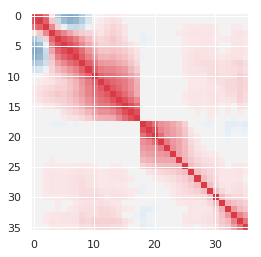

In [308]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

In [309]:
mean[:,:18].mean(axis=0)

array([ 1211.27742179,   905.61215959,   668.2211048 ,   479.32345381,
         333.45002559,   226.88579685,   150.02880378,    96.83049346,
          63.12084246,    43.19020457,    31.59819527,    23.90396022,
          17.97293158,    13.04180767,     8.98226571,     5.76941245,
           3.33579944,     1.65068684])

In [310]:
print np.sqrt(np.diag(full_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)
print np.sqrt(np.diag(emu_cov[:18, :18]) )/wp_hod#mean[:-1, :18].mean(axis=0)

[ 0.01772151  0.0165684   0.01699054  0.01621152  0.01621031  0.01597432
  0.01563625  0.01625811  0.01665975  0.01537595  0.01472091  0.01403948
  0.01488573  0.01730812  0.02076087  0.02790995  0.03943242  0.07434265]
[ 0.0771002   0.05420811  0.03027814  0.02590637  0.03193232  0.03460633
  0.03089772  0.0241689   0.01794381  0.01409014  0.01040717  0.01075583
  0.01345373  0.01449076  0.01590892  0.02334045  0.03495713  0.06829029]


In [311]:
np.sqrt(np.diag(full_emu_cov[:18, :18]) )/mean[:-1, :18].mean(axis=0)

array([ 0.09729608,  0.06813433,  0.03953857,  0.03486732,  0.0425332 ,
        0.04882616,  0.04999692,  0.04767499,  0.04472649,  0.04031824,
        0.03576113,  0.03521633,  0.0400385 ,  0.04539071,  0.0525201 ,
        0.0749349 ,  0.10778257,  0.20917204])

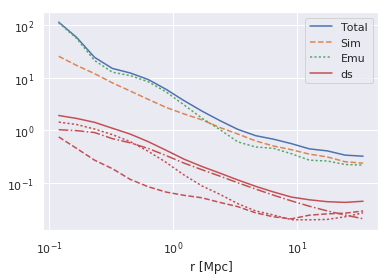

In [312]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'Total')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), ls = '--', label = 'Sim')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), ls = ':', label = 'Emu')


plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

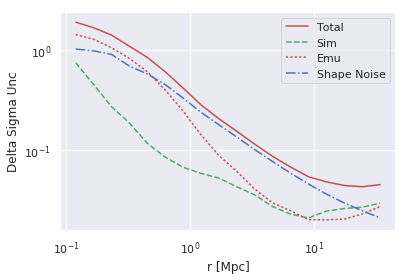

In [313]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':', label = 'Emu')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [314]:
0.7**2

0.48999999999999994